# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


    class Model:
        
        def predict(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of predicted classes.

        def certainty(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of certainty levels.

In [40]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [46]:
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


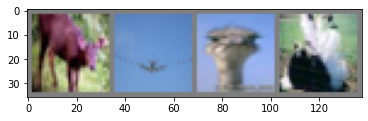

deer  plane bird  bird 


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from turtle import down
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, end_expansion):
        super(Block, self).__init__()
        self.end_expansion = end_expansion
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
        self.batch_norm_1 = nn.BatchNorm2d(out_channels)
        self.conv_2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride)
        self.batch_norm_2 = nn.BatchNorm2d(out_channels)
        self.conv_3 = nn.Conv2d(in_channels=in_channels, out_channels=self.end_expansion*out_channels, kernel_size=1, stride=stride)
        self.batch_norm_3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

        def forward(self, x):
            input_x = x.clone()
            x = self.relu(self.batch_norm_1(self.conv_1(x)))
            x = self.relu(self.batch_norm_2(self.conv_2(x)))
            x = self.batch_norm_3(self.conv_3(x))

            # skip connection
            x = self.relu(x + input_x)

            return x

class MyResNet50(nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.in_channels = 64
        self.end_bl_expansion = 4

        self.input_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.blocks_layers_1 = self.make_block_layer(sublayers_num=3, bl_input_channels=64, downsample_first = False)
        self.blocks_layers_2 = self.make_block_layer(sublayers_num=4, bl_input_channels=128, downsample_first = True)
        self.blocks_layers_3 = self.make_block_layer(sublayers_num=6, bl_input_channels=256, downsample_first = True)
        self.blocks_layers_4 = self.make_block_layer(sublayers_num=3, bl_input_channels=512, downsample_first = True)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*self.end_bl_expansion, 10)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.input_conv(x)))
        x = self.max_pool(x)
        x = self.blocks_layers_1(x)
        x = self.blocks_layers_2(x)
        x = self.blocks_layers_3(x)
        x = self.blocks_layers_4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

    def make_blocks_layer(self, sublayers_num, bl_input_channels, downsample_first):
        blocks_layers = []
        for i in range(sublayers_num-1):
            if i == 0 and downsample_first:
                blocks_layers.append(Block(bl_input_channels/2, bl_input_channels))
            else:
                blocks_layers.append(Block(bl_input_channels, bl_input_channels))
        
        blocks_layers.append(Block(bl_input_channels, self.end_bl_expansion*bl_input_channels))

        return nn.Sequential(*blocks_layers)


